In this file we predict the future prediction of the navier stokes equation from the previous frames

In [1]:
from phi.flow import *
import numpy as np
from phi.field import curl
from tqdm.notebook import trange
import sys
sys.path.insert(1, r'C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\2D-Turbulence-Python\\src')
sys.path.insert(2, r'C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\codes')
from field import TaylorGreen,L2,Linf,McWilliams, TaylorGreen
from fluid import Fluid
from model_with_convolution1D import *
from DataGenerator import *
import matplotlib.pyplot as plt

In [2]:
#model parameters
domain = Box(x=64, y=64)  # Define the simulation grid size
DOMAIN = dict(x=64, y=64)
frame_number = 20
block_size = 8
dt = 0.5  # Time step size

In [3]:
def generate_initial_field():
    flow = Fluid(64, 64, Re=100.)
    flow.init_solver()
    flow.init_field(McWilliams)

    u, v = flow.get_vel()

    #velocity to staggered grid
    u_tensor = tensor(u, spatial('x,y'))
    v_tensor = tensor(v, spatial('x,y'))
    v0 = StaggeredGrid(math.stack([u_tensor, v_tensor], dual(vector='x,y')), extrapolation.PERIODIC)

    v0, _ = fluid.make_incompressible(v0, (), Solve('CG', 1e-3, x0=None)) #to ensure divergence free field we make it incompressable
    return v0

In [4]:
#with iteration faster
@jit_compile
def step(v, dt):
    v = advect.semi_lagrangian(v, v, dt=dt)
    v, _ = fluid.make_incompressible(v, (), Solve('CG', 1e-3, x0=None))
    return v

#generate multiple simulation with diffrent intial state
trj_list = []
v0 = generate_initial_field()
#plot(curl(v0))
v_trj = iterate(step, batch(time=frame_number), v0,dt=dt, range=trange, substeps=1)
trj_list.append(v_trj)


c:\Users\onurb\anaconda3\envs\cuda\Lib\site-packages\phiml\math\_optimize.py:631: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")
c:\Users\onurb\anaconda3\envs\cuda\Lib\site-packages\phiml\backend\torch\_torch_backend.py:800: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)


  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\onurb\anaconda3\envs\cuda\Lib\site-packages\phiml\math\_optimize.py:631: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


In [5]:
#c_trajectory = curl(v_trajectory)
plot(v_trj, animate='time', frame_time=120, overlay='args')

Let's instantiate the transolver model

In [6]:
from model import Transolver_Structured_Mesh_2D
import torch

c:\Users\onurb\anaconda3\envs\cuda\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [10]:
model = Transolver_Structured_Mesh_2D.Model(space_dim=2,
                                  n_layers=8,
                                  n_hidden=256,
                                  dropout=0.0,
                                  n_head=8,
                                  Time_Input=False,
                                  fun_dim=10,
                                  out_dim=2,
                                  unified_pos=0,
                                  H=64, W=64).cuda()

In [11]:
save_name = "ns_Transolver_epoch50_f20"
model.load_state_dict(torch.load("./checkpoints/" + save_name + ".pt"), strict=False)
model.eval()

C:\Users\onurb\AppData\Local\Temp\ipykernel_18680\2657572427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoints/" + save_nam

Model(
  (preprocess): MLP(
    (linear_pre): Sequential(
      (0): Linear(in_features=12, out_features=512, bias=True)
      (1): GELU(approximate='none')
    )
    (linear_post): Linear(in_features=512, out_features=256, bias=True)
    (linears): ModuleList()
  )
  (blocks): ModuleList(
    (0-6): 7 x Transolver_block(
      (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (Attn): Physics_Attention_Structured_Mesh_2D(
        (softmax): Softmax(dim=-1)
        (dropout): Dropout(p=0.0, inplace=False)
        (in_project_x): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (in_project_fx): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (in_project_slice): Linear(in_features=32, out_features=32, bias=True)
        (to_q): Linear(in_features=32, out_features=32, bias=False)
        (to_k): Linear(in_features=32, out_features=32, bias=False)
        (to_v): Linear(in_features=32, out_features=32, bias=False)
    

In [ ]:
#resahape x (1,4096,2)
h = 64
x = np.linspace(0, 1, h)
y = np.linspace(0, 1, h)
x, y = np.meshgrid(x, y)
pos = np.c_[x.ravel(), y.ravel()]
pos1 = torch.tensor(pos, dtype=torch.float).unsqueeze(0).cuda()
print(pos1.shape)

#reshape fx (1,4096,10) [vel1x, vel1y, vel2x, vel2y,... vel5x, vel5y]
buff = np.empty((1,4096,10))
fx = v_trj.time[0:5].numpy()
vel_x = fx[0].reshape(4096,5)
vel_y = fx[1].reshape(4096,5)
buff[:,:,0::2] = vel_x
buff[:,:,1::2] = vel_y
fx = torch.tensor(buff, dtype=torch.float).cuda()
print(fx.shape)

(4096, 2)
torch.Size([1, 4096, 10])


In [ ]:
#predict
im = model(pos1, fx)
print(im.shape)
im_np = im[0, :, :].reshape(64, 64, 2).detach().cpu().numpy()
print(im_np.shape)

torch.Size([1, 4096, 2])
(64, 64, 2)


torch.Size([1, 4096])
(xˢ=64, yˢ=64, vectorᶜ=x,y)


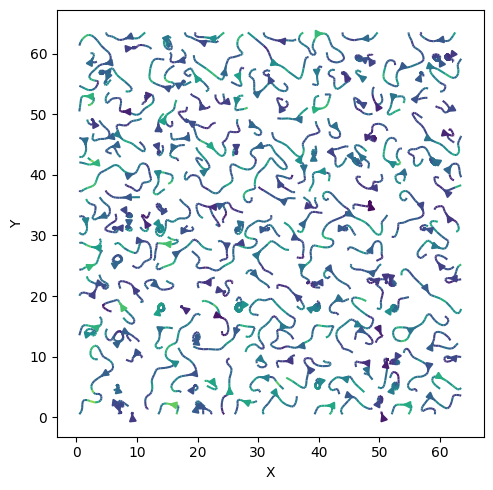

In [14]:
from phi.torch.flow import *

vx = im[:,:,0]
vy = im[:,:,1]
print(vy.shape)

vx_field = vx.reshape(64,64)
vy_field = vy.reshape(64,64)

# Convert to PhiFlow tensors
vx_field = tensor(vx_field, spatial('x,y'))
vy_field = tensor(vy_field, spatial('x,y'))

# Create a StaggeredGrid for the velocity field
field = StaggeredGrid(math.stack([vx_field, vy_field], dual(vector='x,y')), extrapolation.PERIODIC)

print(field.shape)
plot(field)
plt.show()

(xˢ=64, yˢ=64, vectorᶜ=x,y)


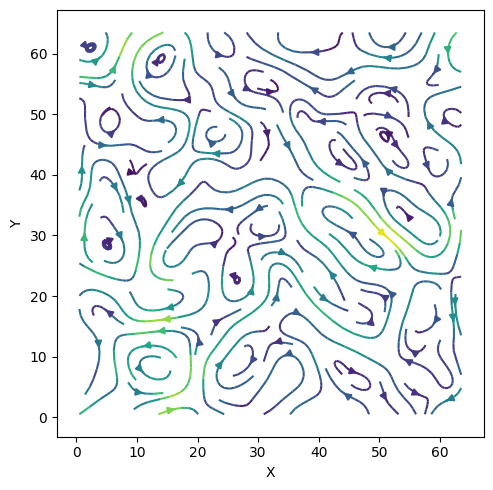

In [15]:
#gt
gt = v_trj.time[5]
print(gt.shape)
plot(gt)
plt.show()

Compare it with the training dataset

tensor([[[-0.2080,  1.1387, -0.1072,  ...,  1.0702,  0.0459,  1.0351],
         [-0.5355,  1.2380, -0.4250,  ...,  1.1707, -0.2054,  1.1430],
         [-0.6230,  1.2655, -0.5824,  ...,  1.2257, -0.3935,  1.2006],
         ...,
         [ 1.1621,  0.4180,  1.1750,  ...,  0.2493,  1.1803,  0.2016],
         [ 0.7860,  0.7044,  0.8030,  ...,  0.4921,  0.8711,  0.4120],
         [ 0.3441,  0.8922,  0.3913,  ...,  0.7022,  0.5264,  0.6150]]],
       device='cuda:0')
tensor(0.1900, device='cuda:0', grad_fn=<SumBackward0>)
(xˢ=64, yˢ=64, vectorᶜ=x,y)


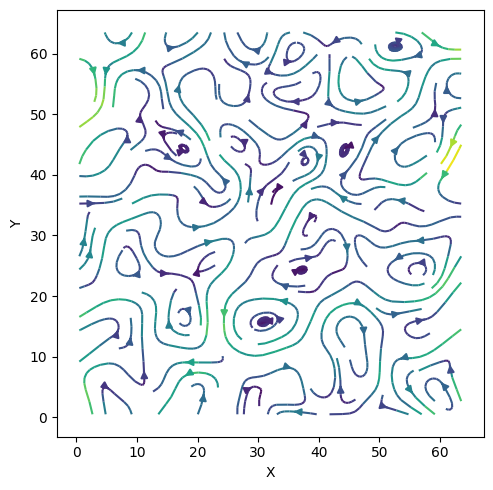

In [90]:
data_path = r"C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\Transolver\\PDE-Solving-StandardBenchmark\\data\\ns_200_20.npy"
data = np.load(data_path) #200, 64, 64, 12
test = data[-20, :, :, :12] # 64, 64, 12
test = test.reshape(1, -1, test.shape[-1]) #1, 4096, 12
test = torch.from_numpy(test)

y2 = test[..., 10:12].cuda()
fx2 = test[...,:10].cuda()

print(fx2)

im2 = model(pos1, fx=fx2)

loss = torch.sum(torch.pow(im2.reshape(1, -1) - y2.reshape(1, -1),2))
print(loss)

vx = im2[0,:,0]
vy = im2[0,:,1]

vx_field = vx.reshape(64,64)
vy_field = vy.reshape(64,64)

# Convert to PhiFlow tensors
vx_field = tensor(vx_field, spatial('x,y'))
vy_field = tensor(vy_field, spatial('x,y'))

# Create a StaggeredGrid for the velocity field
field = StaggeredGrid(math.stack([vx_field, vy_field], dual(vector='x,y')), extrapolation.PERIODIC)

print(field.shape)
plot(field)
plt.show()

im torch.Size([1, 4096, 2]), y torch.Size([1, 4096, 2])
tensor(0.3590, device='cuda:0')
(xˢ=64, yˢ=64, vectorᶜ=x,y)


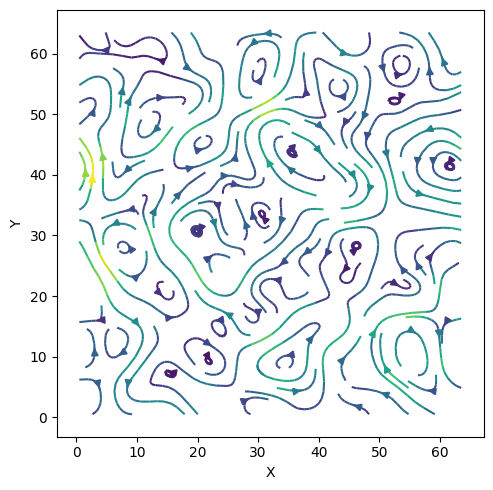

In [72]:
test_a = data[-1:, ::1, ::1, :10][:, :64, :64, :]
test_a = test_a.reshape(test_a.shape[0], -1, test_a.shape[-1])
test_a = torch.from_numpy(test_a)
test_u = data[-1:, ::1, ::1, 10:10 + 10][:, :64, :64, :]
test_u = test_u.reshape(test_u.shape[0], -1, test_u.shape[-1])
test_u = torch.from_numpy(test_u)

x = np.linspace(0, 1, h)
y = np.linspace(0, 1, h)
x, y = np.meshgrid(x, y)
pos = np.c_[x.ravel(), y.ravel()]
pos = torch.tensor(pos, dtype=torch.float).unsqueeze(0)
pos_test = pos.repeat(1, 1, 1)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(pos_test, test_a, test_u),
                                              batch_size=1, shuffle=False)

with torch.no_grad():
    for x, fx, yy in test_loader:
        x, fx, yy = x.cuda(), fx.cuda(), yy.cuda()  # x : B, 4096, 2  fx : B, 4096  y : B, 4096, T
        bsz = x.shape[0]
        for t in range(0, 2, 2):
            im = model(x, fx=fx)
            y = yy[..., t:t + 2]
            print(f"im {im.shape}, y {y.shape}")

            l = torch.sum(torch.pow(im[0].reshape(1, -1) - y[0].reshape(1, -1),2))
            print(l)

            vx = im[0,:,0]
            vy = im[0,:,1]

            vx_field = vx.reshape(64,64)
            vy_field = vy.reshape(64,64)

            # Convert to PhiFlow tensors
            vx_field = tensor(vx_field, spatial('x,y'))
            vy_field = tensor(vy_field, spatial('x,y'))

            # Create a StaggeredGrid for the velocity field
            field = StaggeredGrid(math.stack([vx_field, vy_field], dual(vector='x,y')), extrapolation.PERIODIC)

            print(field.shape)
            plot(field)
            plt.show()

            fx = torch.cat((fx[..., 2:], im), dim=-1)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)
